In [24]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import datetime

from models.gru_stacked import Generator, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_to_tensorboard, plot_anomaly_scores, plot_train_hist
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss, feature_anomaly_score

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 32
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        self.method = "window_mag"
        # self.nseqs = 4
        self.scaler = MinMaxScaler((-1,1))
        self.wsize = 5
        
        # Train params
        self.lr = 0.0001
        self.epochs = 25
        self.G_niters = 5
        self.D_niters = 10
        
        self.model_out = Path('./runs/gru_stack/' + time_id + '_w5')
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        
        (self.model_out / "img").mkdir(exist_ok=True)
        
opts = Options()


# Setup Training Dataset

In [25]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=True,
    is_train=True,
    scaler=opts.scaler,
    # nseqs=opts.nseqs
    window_size=opts.wsize,
    # use_pca=True,
    # pca_scaler=MinMaxScaler((-1,1)),
    # n_components=128   
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Window size: 5
Window shape:  torch.Size([5, 640])
First window:
 tensor([[-0.4835, -0.4830, -0.4826,  ...,  0.9998,  0.9998,  0.9999],
        [-0.4728, -0.4724, -0.4719,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4461, -0.4456, -0.4452,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4908, -0.4903, -0.4899,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4562, -0.4557, -0.4553,  ...,  0.9999,  0.9999,  0.9999]])
Inputs shape: (11066, 640)
Inputs head:
 [[-0.4834911  -0.48303799 -0.48258295 ...  0.99983155  0.99984836
   0.99986353]
 [-0.47284225 -0.4723928  -0.47194147 ...  0.99986533  0.99987877
   0.99989089]
 [-0.44609133 -0.44563623 -0.44517925 ...  0.99987057  0.99988349
   0.99989514]
 [-0.49076893 -0.49033704 -0.4899033  ...  0.99988016  0.99989212
   0.99990291]
 [-0.45617043 -0.45574015 -0.45530805 ...  0.99986605  0.99987941
   0.99989148]]


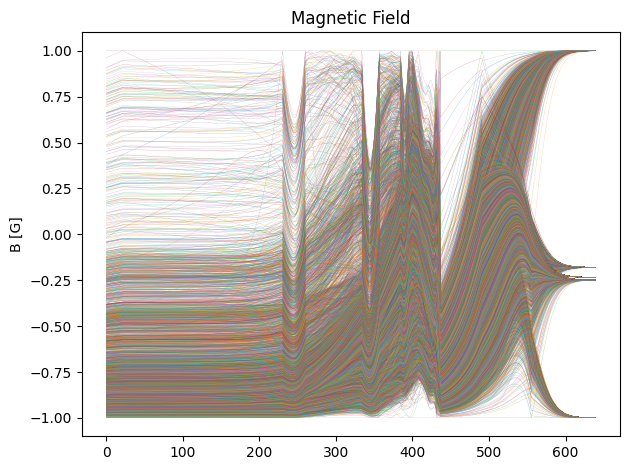

In [26]:
dataset.plot(title="Magnetic Field")

# Models

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[1],
    hidden_size=150,
    output_size=dataset.inputs.shape[1],
    device=device,
    num_layers=1
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[1],
    hidden_size=150,
    num_layers=1,
    device=device
).to(device)

print(netG, netD)

Using device:  cuda:0
Generator(
  (main): GRU(640, 150, num_layers=3, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=150, out_features=640, bias=True)
  )
) Discriminator(
  (main): GRU(640, 150, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=150, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [28]:
netG.train()

Generator(
  (main): GRU(640, 150, num_layers=3, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=150, out_features=640, bias=True)
  )
)

In [29]:
netD.train()

Discriminator(
  (main): GRU(640, 150, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=150, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [30]:
logger = SummaryWriter(f"logs/gru_stack/{time_id}_D{netD.hidden_size}-L{netD.num_layers}_G{netG.hidden_size}-L{netG.num_layers}")
logger.add_graph(netG, torch.randn(opts.batch_size, opts.wsize, dataset.inputs.shape[1]).to(device))
logger.add_graph(netD, torch.randn(opts.batch_size,opts.wsize, dataset.inputs.shape[1]).to(device))
logger.add_text("Generator", netG.__str__())
logger.add_text("Discriminator", netD.__str__())

with open(opts.model_out / "model.txt", "w") as f:
    f.write("Generator" + str(netG) + "\n")
    f.write("Discriminator" + str(netD) + "\n")

# Training

In [31]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

nseqs = opts.wsize

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.lr)

In [32]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for i, (x, _filename) in tqdm(enumerate(dataloader), desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader), leave=False):
        
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, nseqs, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        for _ in range(opts.D_niters):
            netD.zero_grad()
            
            # Train with real batch
            output = netD(real)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            # Train with fake batch
            fake = netG(torch.randn_like(real, device=device))
            fake_labels = torch.full((b_size, nseqs, 1), fake_label, dtype=torch.float, device=device)
            
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        for _ in range(opts.G_niters):
            netG.zero_grad()
            
            fake = netG(torch.randn_like(real, device=device))
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        logger.add_scalars('Loss/train', {'G': errG.item(), 'D': errD.item()}, iters)
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.randn_like(real, device=device))
    output = netD(fake.detach())
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1))

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 1 and D_x > 0.7: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            fake = dataset.unscale(fake.detach().cpu().numpy())
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f"img/{epoch}_best", dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/best")
            plt.close(fig)
    elif epoch % 5 == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            # fake = dataset.flatten(fake.detach().cpu().numpy())
            fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f'img/inter_{epoch}.png', dpi=200)
            plot_to_tensorboard(logger, fig, epoch, "train/inter")
            plt.close(fig)
            
        train_f = plot_train_hist(D_losses, G_losses, opts.model_out)
        plt.close(train_f)
    

Starting Training Loop...


Epoch [0/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[0/25]	Loss_D: 0.1849	Loss_G: 3.0122	D(x): 0.9357	D(G(z)): 0.0913


Epoch [1/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[1/25]	Loss_D: 0.0695	Loss_G: 4.5011	D(x): 0.9658	D(G(z)): 0.0295


Epoch [2/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[2/25]	Loss_D: 0.0643	Loss_G: 5.3664	D(x): 0.9851	D(G(z)): 0.0408


Epoch [3/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[3/25]	Loss_D: 0.0544	Loss_G: 4.7181	D(x): 0.9826	D(G(z)): 0.0290


Epoch [4/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[4/25]	Loss_D: 0.2976	Loss_G: 2.5191	D(x): 0.9624	D(G(z)): 0.1633


Epoch [5/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[5/25]	Loss_D: 0.2797	Loss_G: 3.3437	D(x): 0.8769	D(G(z)): 0.0712


Epoch [6/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[6/25]	Loss_D: 0.3150	Loss_G: 2.3602	D(x): 0.9261	D(G(z)): 0.1408


Epoch [7/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[7/25]	Loss_D: 0.5320	Loss_G: 1.2185	D(x): 0.9113	D(G(z)): 0.3193


Epoch [8/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[8/25]	Loss_D: 0.4677	Loss_G: 2.4377	D(x): 0.8711	D(G(z)): 0.1006


Epoch [9/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[9/25]	Loss_D: 0.6845	Loss_G: 1.6290	D(x): 0.7599	D(G(z)): 0.2415


Epoch [10/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[10/25]	Loss_D: 0.4069	Loss_G: 2.1650	D(x): 0.8838	D(G(z)): 0.1343


Epoch [11/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[11/25]	Loss_D: 0.4460	Loss_G: 1.5509	D(x): 0.9320	D(G(z)): 0.2758


Epoch [12/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[12/25]	Loss_D: 0.3130	Loss_G: 2.2101	D(x): 0.9220	D(G(z)): 0.1347


Epoch [13/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[13/25]	Loss_D: 0.6461	Loss_G: 1.5465	D(x): 0.8223	D(G(z)): 0.2255


Epoch [14/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[14/25]	Loss_D: 0.5651	Loss_G: 1.9910	D(x): 0.8146	D(G(z)): 0.1496


Epoch [15/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[15/25]	Loss_D: 0.3513	Loss_G: 2.3640	D(x): 0.8879	D(G(z)): 0.1064


Epoch [16/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[16/25]	Loss_D: 0.4563	Loss_G: 2.1888	D(x): 0.8561	D(G(z)): 0.1287


Epoch [17/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[17/25]	Loss_D: 0.6873	Loss_G: 1.1561	D(x): 0.8412	D(G(z)): 0.3540


Epoch [18/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[18/25]	Loss_D: 0.4147	Loss_G: 1.6734	D(x): 0.8969	D(G(z)): 0.2070


Epoch [19/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[19/25]	Loss_D: 0.4504	Loss_G: 2.4623	D(x): 0.8707	D(G(z)): 0.0978


Epoch [20/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[20/25]	Loss_D: 0.3987	Loss_G: 1.6546	D(x): 0.8864	D(G(z)): 0.2051


Epoch [21/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[21/25]	Loss_D: 0.3621	Loss_G: 2.6276	D(x): 0.8871	D(G(z)): 0.0833


Epoch [22/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[22/25]	Loss_D: 0.0514	Loss_G: 3.5707	D(x): 0.9998	D(G(z)): 0.0437


Epoch [23/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[23/25]	Loss_D: 0.3940	Loss_G: 2.2569	D(x): 0.8910	D(G(z)): 0.1442


Epoch [24/25]:   0%|          | 0/346 [00:00<?, ?it/s]

[24/25]	Loss_D: 0.3900	Loss_G: 2.1010	D(x): 0.8904	D(G(z)): 0.1565


In [33]:
logger.flush()

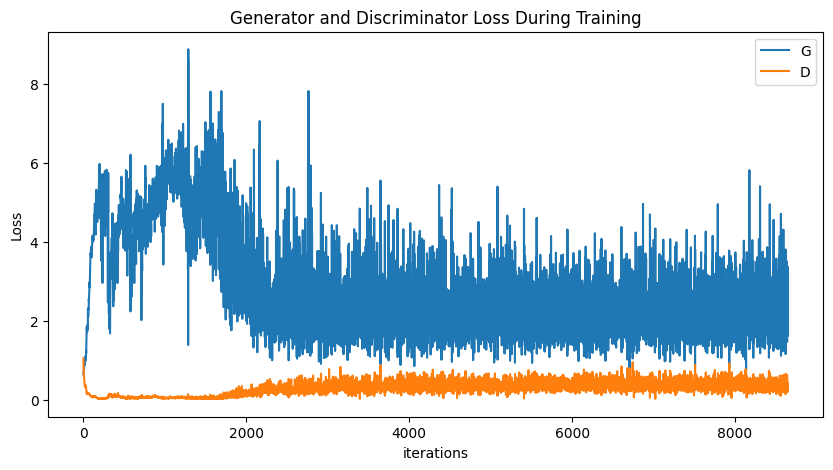

In [34]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Anomaly Detection

In [35]:

netD.train(True)
netG.train(True)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("./runs/gru_pyr/0313-2017_w5")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netG.load_state_dict(torch.load(opts_eval.models_dir / 'Gbest.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'Dbest.pth'))

<All keys matched successfully>

In [36]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Window size: 5
Window shape:  torch.Size([5, 640])
First window:
 tensor([[-0.4835, -0.4830, -0.4826,  ...,  0.9998,  0.9998,  0.9999],
        [-0.4728, -0.4724, -0.4719,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4461, -0.4456, -0.4452,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4908, -0.4903, -0.4899,  ...,  0.9999,  0.9999,  0.9999],
        [-0.4562, -0.4557, -0.4553,  ...,  0.9999,  0.9999,  0.9999]])
Inputs shape: (11771, 640)
Inputs head:
 [[-0.4834911  -0.48303799 -0.48258295 ...  0.99983155  0.99984836
   0.99986353]
 [-0.47284225 -0.4723928  -0.47194147 ...  0.99986533  0.99987877
   0.99989089]
 [-0.44609133 -0.44563623 -0.44517925 ...  0.99987057  0.99988349
   0.99989514]
 [-0.49076893 -0.49033704 -0.4899033  ...  0.99988016  0.99989212
   0.99990291]
 [-0.45617043 -0.45574015 -0.45530805 ...  0.99986605  0.99987941
   0.99989148]]


## Discriminator Classification

In [37]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # print(outputs.shape)
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        # print(filename)
        class_avg = sample[0]
        scores.append((filename, 1-class_avg.item()))

Anomaly Threshold:  0.6597880423069
Found 1176 anomalies


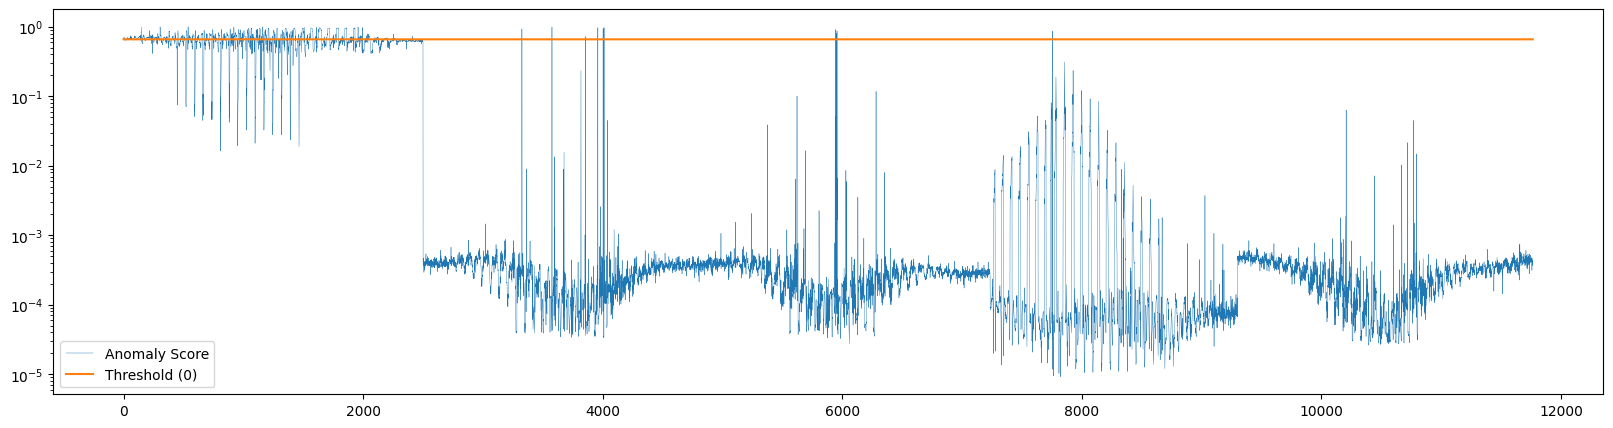

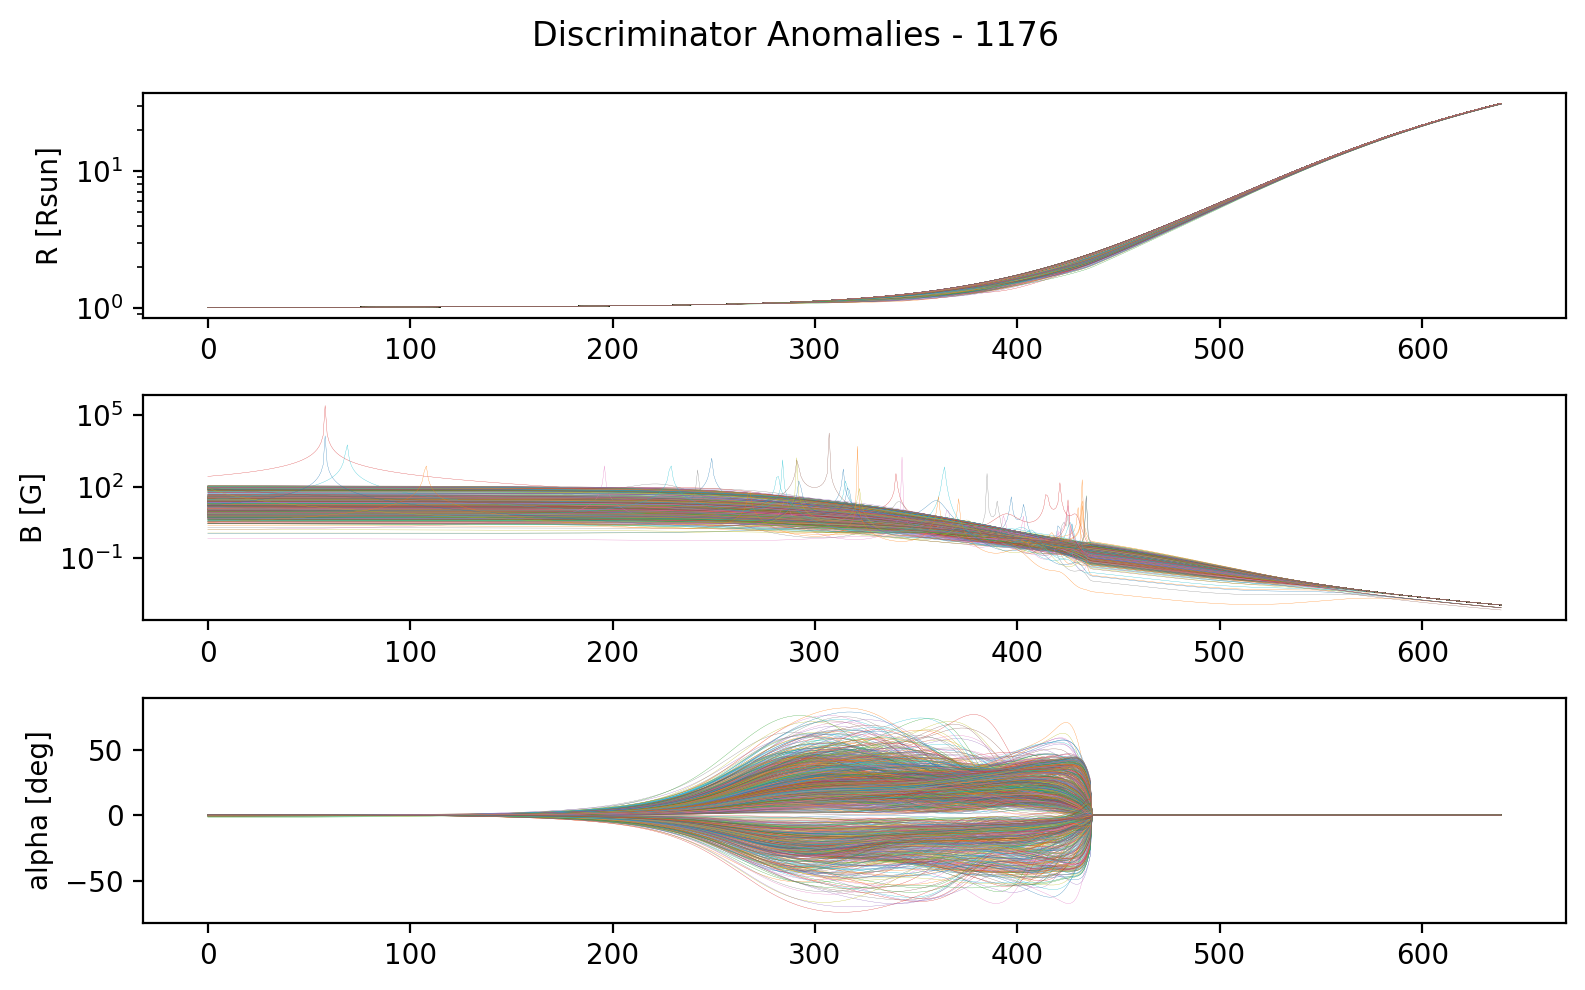

In [38]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/discr_scores",
                        scale="log", method="Discriminator", logger=logger, logger_var="test/discr")

## Reconstruction Based

In [39]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        mse_scores.extend(zip(filenames, [l.sum(-1).detach().cpu().numpy()[0] for l in loss]))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

### MSE Reconstruction

In [40]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, opts_eval.niter, madgan_reconstruction)

Anomaly Threshold:  293.7117
Found 1176 anomalies


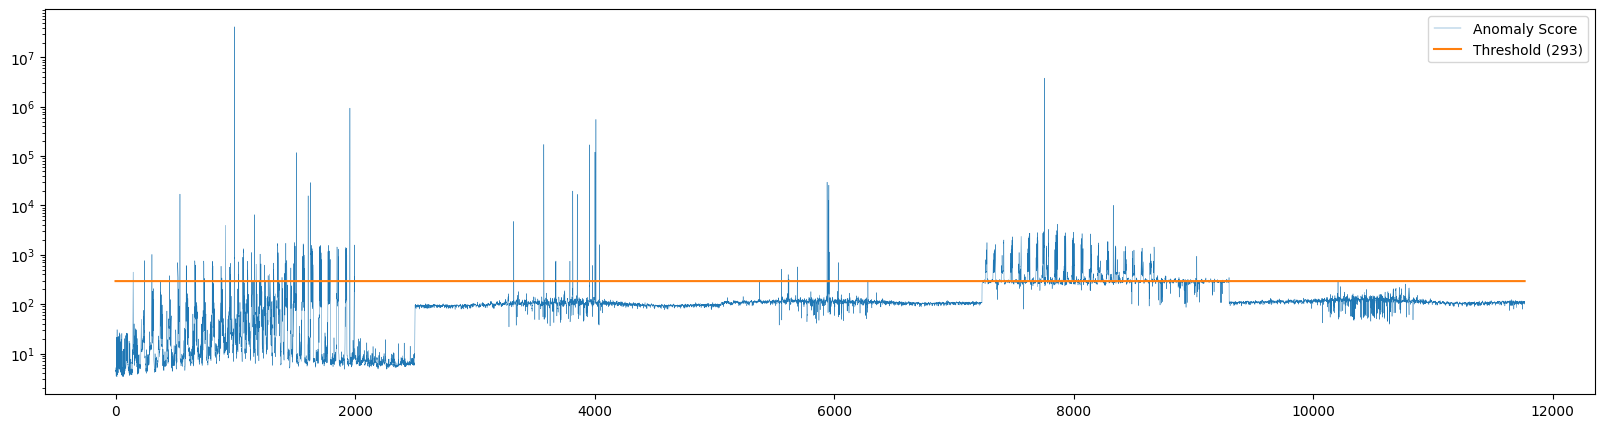

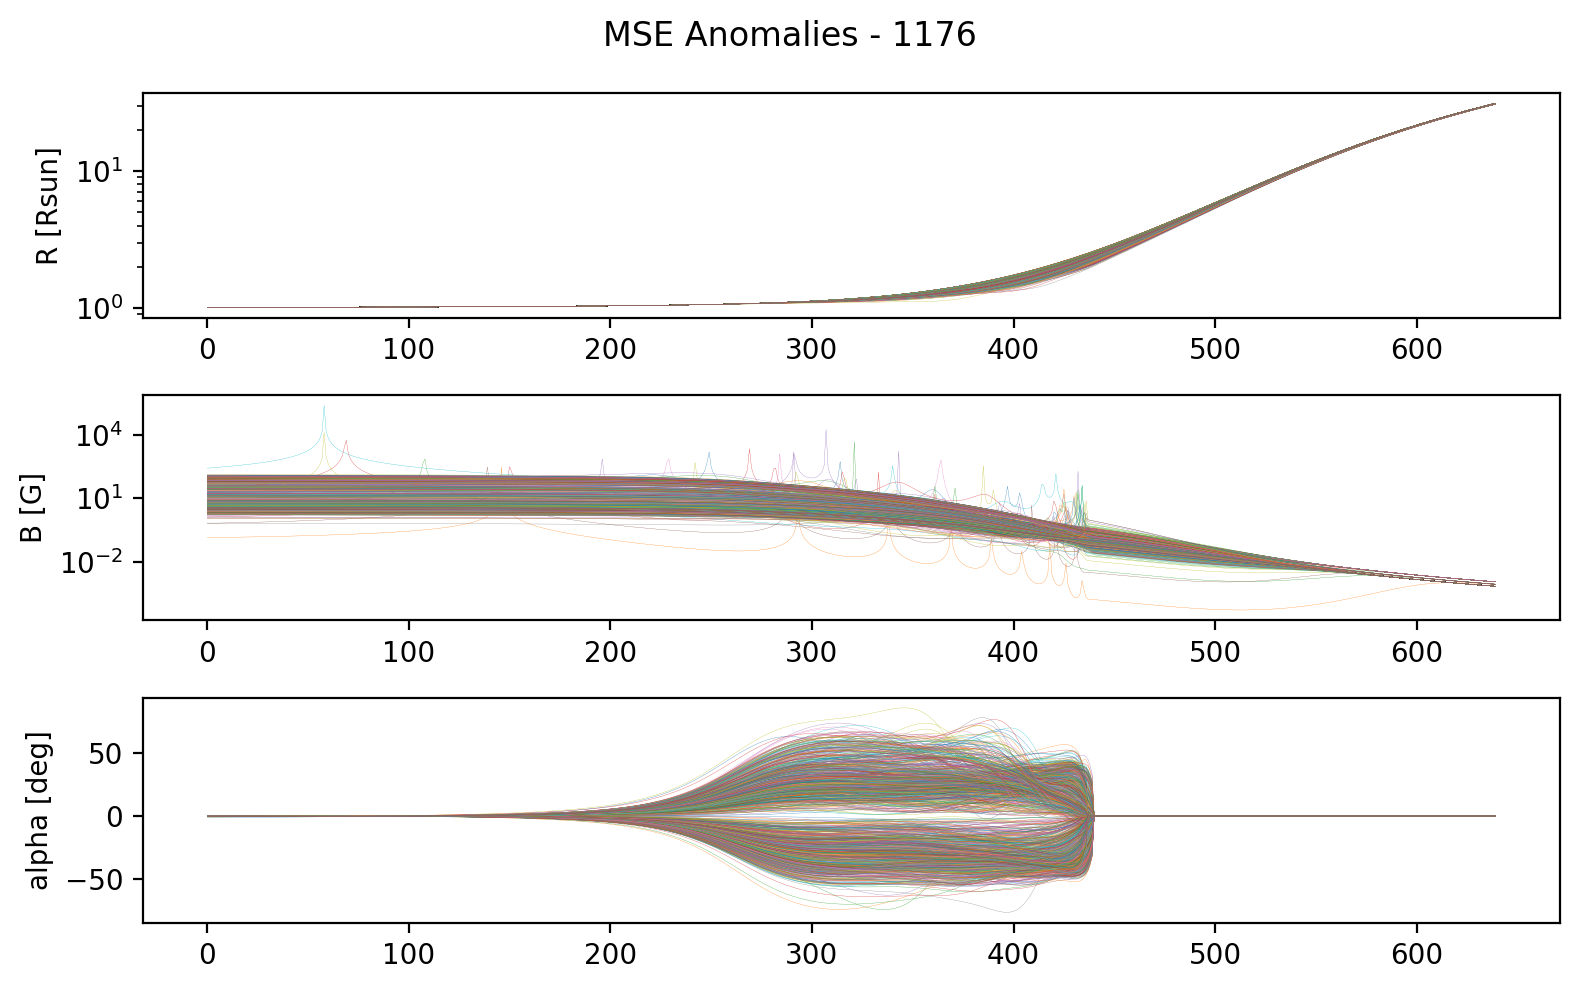

In [41]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse", 
                        scale="log", method="MSE", )

### MSE Reconstruction with Discriminator feedback

In [42]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                      opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  50.519806
Found 1176 anomalies


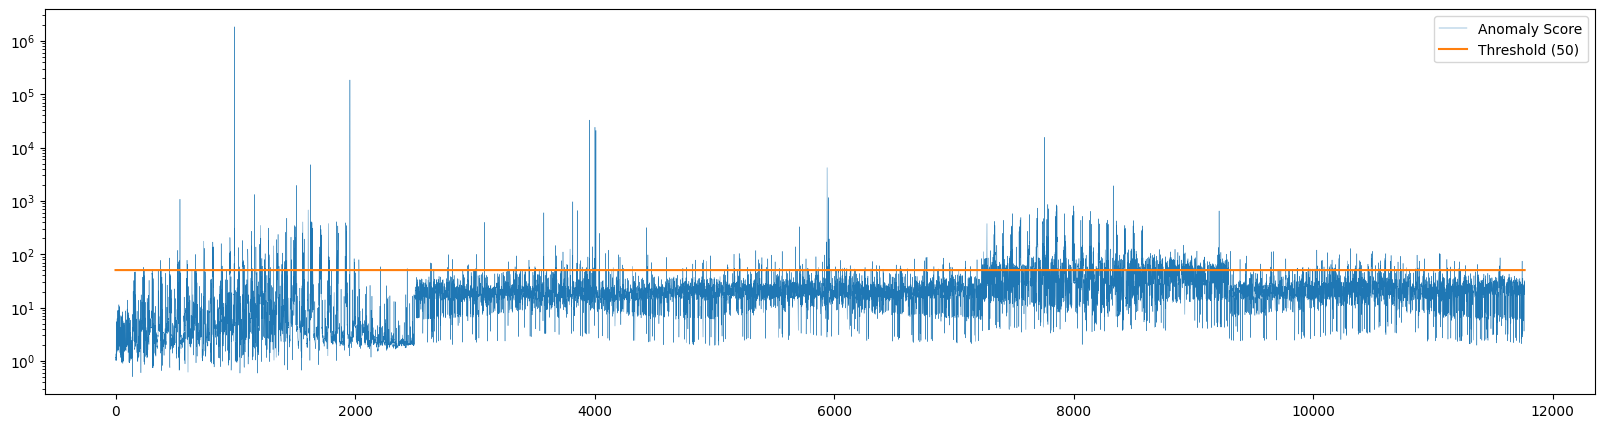

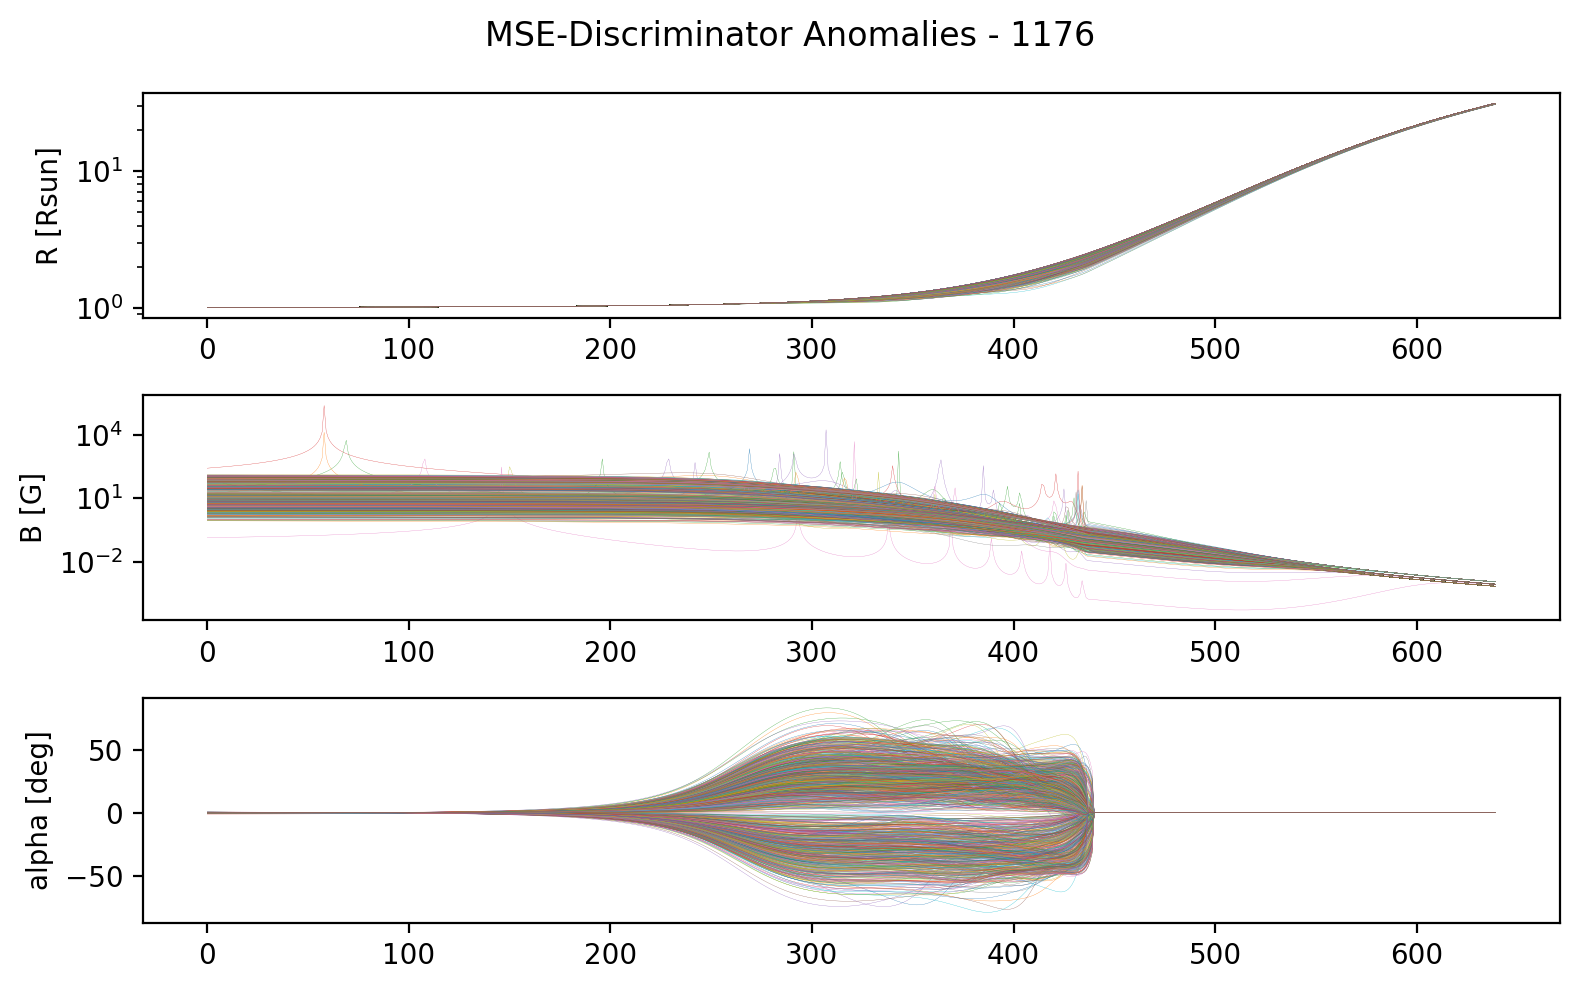

In [43]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_discr",
                        scale="log", method="MSE-Discriminator", logger=logger, logger_var="test/mse_discr")

### Feature Reconstruction

In [44]:
reconstr_feature_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                        opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  52.43048
Found 1176 anomalies


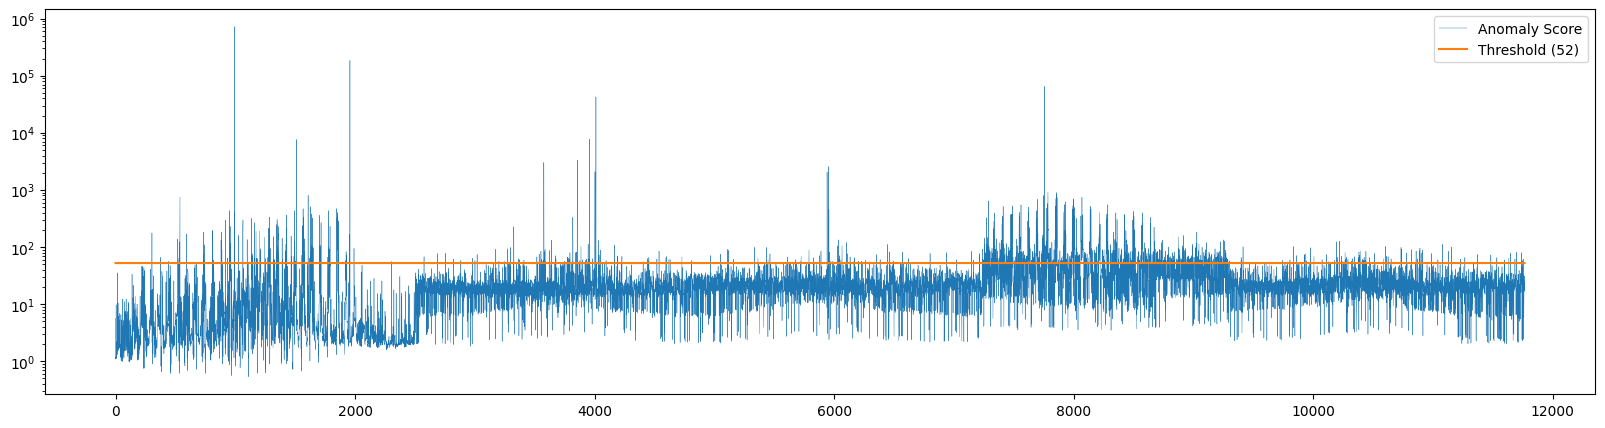

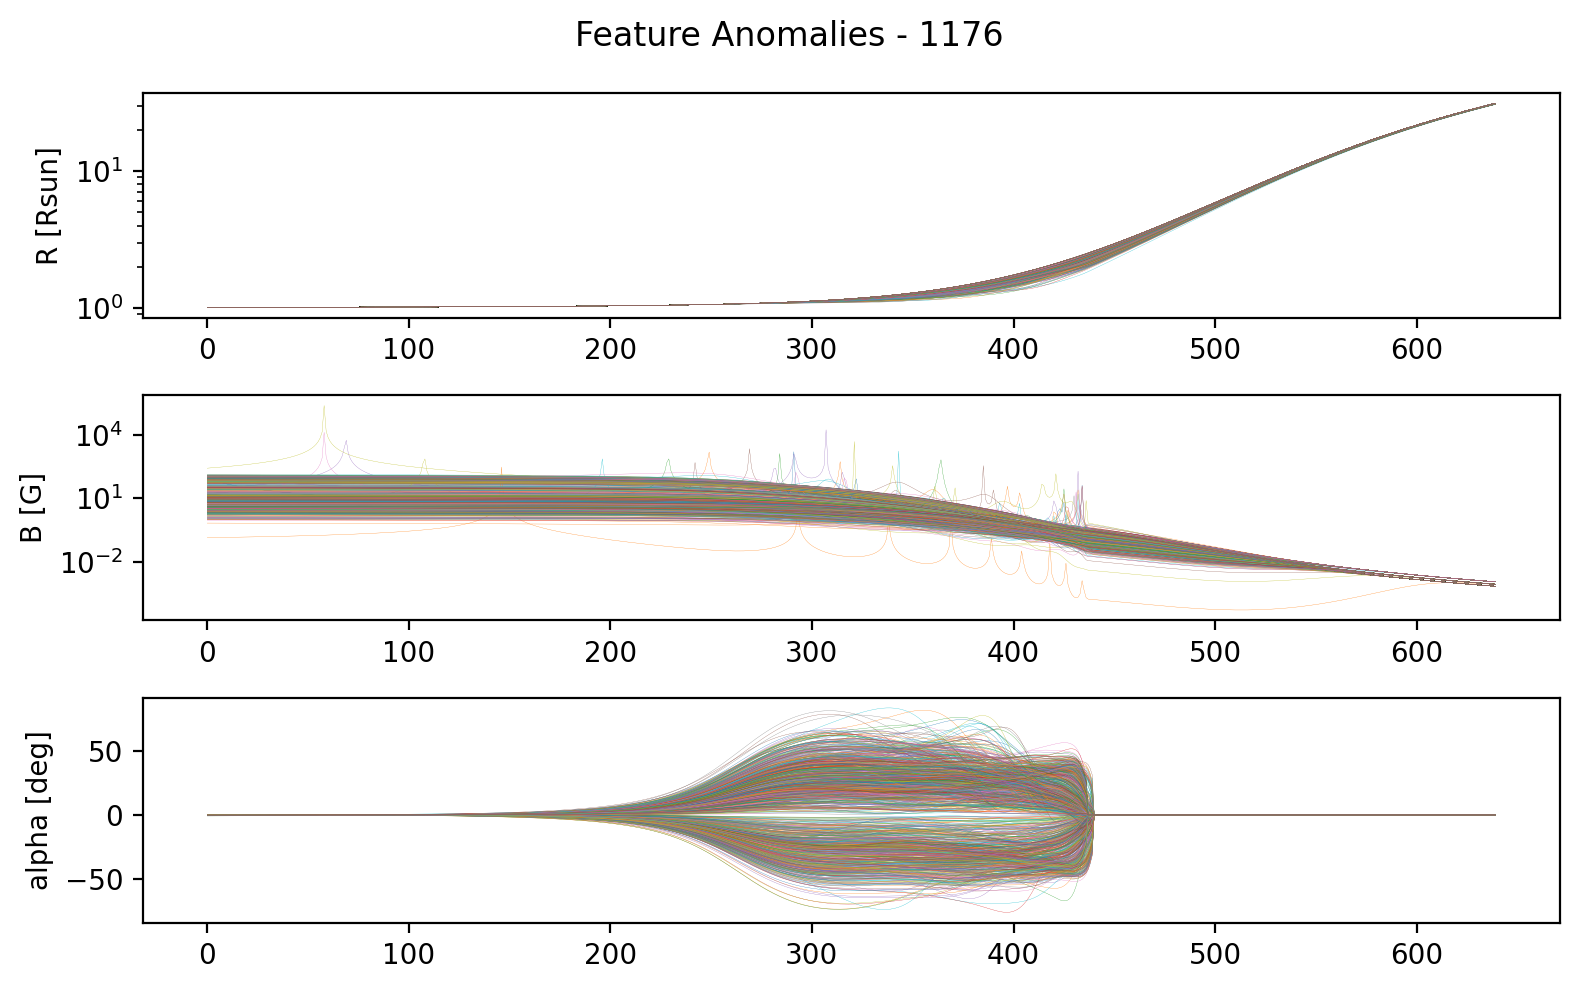

In [45]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_feature_scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/mse_feature",
                        scale="log", method="Feature", logger=logger, logger_var="test/mse_feature")

In [46]:
logger.flush()